DecisionTreeClassifier
RandomForestClassifier

In [1]:
import pandas as pd

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# no duplicate rows
dataset.duplicated().sum()

# show data
dataset.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,False,False,True,Moderate,False,False
1,100001,32,Female,12.780800,High,False,True,True,Moderate,True,True
2,100002,89,Female,0.408278,Medium,True,True,True,None,False,True
3,100003,78,Female,44.065232,Low,False,True,False,Moderate,False,True
4,100004,38,Female,44.432440,Medium,True,False,True,None,True,True


In [2]:
from sklearn.model_selection import train_test_split

# get the data and target from the data frame 
data = dataset.loc[:, 'age':'family_history']
target = dataset['lung_cancer']

train_data, test_data, train_label, test_label = train_test_split(data, target, test_size=0.3, random_state=0)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("cat", OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(train_data)

# Get feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(cat_feature_names)

# Create DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df.head()

,age,pack_years,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,family_history,gender_Male,radon_exposure_Low,radon_exposure_Medium,alcohol_consumption_Moderate,alcohol_consumption_None
0,83,55.808494,True,False,False,False,0.0,0.0,1.0,0.0,0.0
1,23,57.379598,True,True,True,False,0.0,1.0,0.0,0.0,0.0
2,18,75.954741,False,False,True,True,0.0,1.0,0.0,0.0,1.0
3,99,7.654622,True,False,False,False,1.0,1.0,0.0,1.0,0.0
4,47,99.697386,True,False,False,True,1.0,0.0,0.0,1.0,0.0


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Beispiel: dein Preprocessor bleibt gleich
# preprocessor = ...

# Definiere alle Modelle und ihre Parametergrids
models = {
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(random_state=0),
        "params": {
            "clf__max_depth": [4, 6, 8, 10],
            "clf__criterion": ["gini", "entropy"]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(max_depth=6, max_samples=0.75, random_state=0),
        "params": {
            "clf__n_estimators": [30, 40, 50, 60, 70, 80],
            "clf__criterion": ["gini", "entropy"]
        }
    }
}

best_models = {}

for name, cfg in models.items():
    print(f"\n--- GridSearch für {name} ---")
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("clf", cfg["model"])
    ])
    
    grid_search = GridSearchCV(pipeline, cfg["params"], cv=5, n_jobs=-1)
    grid_search.fit(train_data, train_label)
    
    print(f"Beste Parameter für {name}: {grid_search.best_params_}")
    print(f"Bester CV-Score: {grid_search.best_score_ * 100:.2f}%")
    
    best_models[name] = grid_search.best_estimator_

# Optional: Alle Ergebnisse vergleichen
for name, model in best_models.items():
    score = model.score(test_data, test_label) * 100
    print(f"{name} Test-Accuracy: {score:.2f}%")



--- GridSearch für DecisionTreeClassifier ---


/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(

Beste Parameter für DecisionTreeClassifier: {'clf__criterion': 'entropy', 'clf__max_depth': 6}
Bester CV-Score: 73.28%

--- GridSearch für RandomForestClassifier ---
Beste Parameter für RandomForestClassifier: {'clf__criterion': 'entropy', 'clf__n_estimators': 60}
Bester CV-Score: 73.45%
DecisionTreeClassifier Test-Accuracy: 73.75%
RandomForestClassifier Test-Accuracy: 74.21%


In [5]:
import pandas as pd

results = []

for name, model in best_models.items():
    train_acc = model.score(train_data, train_label) * 100
    test_acc = model.score(test_data, test_label) * 100
    results.append({
        "Modell": name,
        "Train Accuracy": f"{train_acc:.2f}%",
        "Test Accuracy": f"{test_acc:.2f}%"
    })

results_df = pd.DataFrame(results)
print(results_df)


                   Modell Train Accuracy Test Accuracy
0  DecisionTreeClassifier         73.65%        73.75%
1  RandomForestClassifier         73.89%        74.21%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

best_model_name = max(best_models, key=lambda name: best_models[name].score(test_data, test_label))
best_model = best_models[best_model_name]

print(f"\nBestes Modell: {best_model_name}")
y_pred = best_model.predict(test_data)

print("\nClassification Report:")
print(classification_report(test_label, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(test_label, y_pred))


Bestes Modell: RandomForestClassifier

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.31      0.43      4681
        True       0.75      0.94      0.83     10319

    accuracy                           0.74     15000
   macro avg       0.72      0.62      0.63     15000
weighted avg       0.73      0.74      0.71     15000


Confusion Matrix:
[[1452 3229]
 [ 640 9679]]


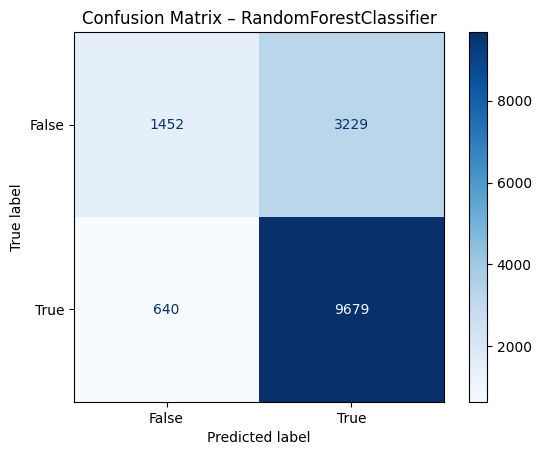

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, test_data, test_label, cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()